# Formal code

In [91]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random

sys.path.append('scripts')
import scripts.gendata as gendata
import scripts.gpu_utils as gu
import scripts.synth_models as synth_models

In [92]:
DEVICE = gu.get_device()

## Part 1: Use SGD to prove the existence of extreme simplicity bias:

### The dataset we use
In this Section, we use the synthetic dataset to detect the existaence of simplicity bias. The idea of this dataset is from the papaer "The Pitfalls of Simplicity Bias in Neural Networks". In the dataset, the concept of simplicity is well-defined. Each dimension has different number of disjoint blocks of data, each block contains datapoints which have the same label. So all dimensions are linear separable, the dimension with less number of blocks is simpler, because it need fewer lines to separate all the blocks.

In [93]:
'''
This is the setting we use to generate the synthetic dataset.
It's very different from the original paper, because we reconstruted all the code so it's more suitbale for our experiments
'''

data_config = {
    'train_num' : 100000,  #Number of training samples
    'test_num' : 10000,  #Number of test samples
    'dim_num' : 50,  #number of feature dimensions for each sample
    'linear_num' : 1,  #number of linear dimension (The dimension with only two blocks)
    'slab3_num' : 1,  #number of dimensions with three different blocks
    'slab5_num' : 1,  #number of dimensions with five different blocks
    'slab7_num' : 1,  #number of dimensions with seven different blocks 
    'linear_margin' : 0.1,  #The distance between diiferent blocks in linear dimension
    'slab3_margin' : 0.1/np.sqrt(2),  #The distance between different blocks in dimension with three blocks
    'slab5_margin' : 0.1/np.sqrt(2),  #The distance between different blocks in dimension with five blocks
    'slab7_margin' : 0.1/np.sqrt(2),  #The distance between different blocks in dimension with seven blocks
    'width' : 1.0,  #The absolut differnce between the largest and the smallest values of a dimension and its center
    'center' : 0.0,   #The position of the center of a dimension
    'linear_p' : 0.0,   #The ratio of samples that lies in the margin area of a dimension
    'attack_p' : 0.0,   #The ratio of samples that have bad label
    'batch_size' : 256   
}

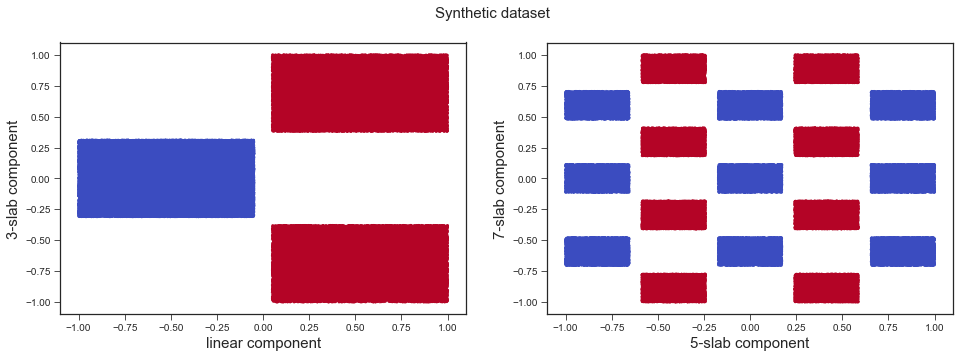

In [94]:
#Here we generate and visualize the dataset with the previous setting
#That has 50 dimensions in total, with one 2-blocks dimension, one 3-blocks dimension, one 5-blocks dimension, and one 7-block dimension
#all other 46 dimensions are random with no prdiction power
data = gendata.get_data(**data_config)
X, Y = data['X'], data['Y']

fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax.set_xlabel('linear component', fontsize=15)
ax.set_ylabel('3-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,3], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax_.set_xlabel('5-slab component', fontsize=15)
ax_.set_ylabel('7-slab component', fontsize=15)
fig.suptitle('Synthetic dataset', fontsize=15);

## Proof of simplicity bias

Now we can fit a model using SGD as optimizer and see whether there's simplicity bias and the level of it if it dose exist. According to the paper, there should be an extreme simplicty bias

In [95]:
#Configurattion to get a MLP model
MLP_model_config = {
    'in_dim' : 50,  #The input dimension of the model
    'hide_dim' : 100,   #The dimension of hidden layer of the model
    'out_dim' : 2,  #The output dimension of the model
    'hidden_layer' : 5,  #The number of the hidden layer of the model
    'activation' : nn.ReLU,   #The activation function
    'use_activation' : True,   #The flag to switch on/off activation function
    'use_bn': False,   #The flag to decide whether using batch normalization
    'use_ln': False,  #The flag to decide whether using layer normalization
    'dropout' : 0.0   #whether use drop out
}

In [97]:
MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
lr = 0.1
opt = optim.SGD(MLP_model.parameters(), lr = lr)
stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)

training ended after  4287.000 itrs


In [ ]:
final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
print('Final accuarcy achieved by this model on test set is : {:.3f}'.format(final_acc[0]))

linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
print('accuarcy after randomized the linear dim : {:.3f}'.format(simple_randomized_acc[0]))

slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
print('accuarcy after randomized the slab3 dim : {:.3f}'.format(slab3_randomized_acc[0]))

other_randomized_loader = gendata.randomized_loader(data['test_dl'], list(range(2, data_config['dim_num'])))
other_randomized_acc = synth_models.get_acc(MLP_model, other_randomized_loader, F.cross_entropy, DEVICE)
print('accuarcy after randomized all the other dims : {:.3f}'.format(other_randomized_acc[0]))

Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.515
accuarcy after randomized the slab3 dim : 1.000
accuarcy after randomized all the other dims : 1.000


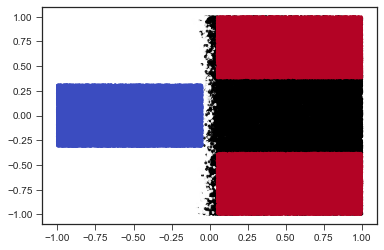

In [ ]:
#To visualize the descision boundary
left_bound = data_config['center'] - data_config['width']
right_bound = data_config['center'] + data_config['width']
X_b, Y_b = synth_models.get_boundaries(MLP_model, left_bound, right_bound, 100000, data_config['dim_num'], DEVICE)
X_b = X_b.cpu()
Y_b = Y_b.cpu()
plt.scatter(X_b[:,0], X_b[:,1], c=Y_b, cmap='Greys', s=4, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 

We can see that the decision boundary of model trained by SGD has extreme simplicity bias, the result is the same compared to the refering paper.

## Try different methods to see how do them effect the existence and level of simplicity bias

### Try using batch normalization

training ended after  3681.000 itrs
When the flag of using batch normalization is :  True
Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.601
accuarcy after randomized the slab3 dim : 0.920
accuarcy after randomized all the other dims : 0.999
training ended after  1426.000 itrs
When the flag of using batch normalization is :  False
Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.515
accuarcy after randomized the slab3 dim : 0.999
accuarcy after randomized all the other dims : 1.000


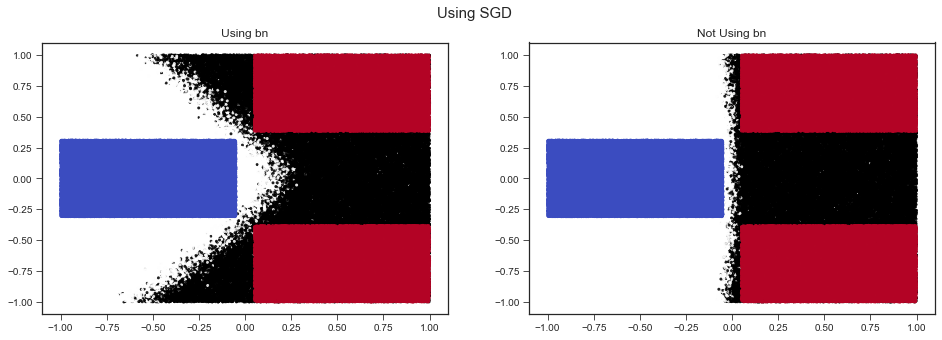

In [ ]:
#First let's set the optimizer to be SGD
bn_flags = [True, False]

fig, ax = plt.subplots(1,2,figsize=(16, 5))
left_bound = data_config['center'] - data_config['width']
right_bound = data_config['center'] + data_config['width']

for i, flag in enumerate(bn_flags):
    MLP_model_config = {
        'in_dim' : 50,
        'hide_dim' : 100,
        'out_dim' : 2,
        'hidden_layer' : 5,
        'activation' : nn.ReLU,
        'use_activation' : True,
        'use_bn': flag,
        'use_ln': False,
        'dropout' : 0.0
    }
    MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
    lr = 0.2
    opt = optim.SGD(MLP_model.parameters(), lr = lr)
    stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
    final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
    print("When the flag of using batch normalization is : ", flag)
    print('Final accuarcy achieved by this model on test set is : {:.3f}'.format(final_acc[0]))

    linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
    simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the linear dim : {:.3f}'.format(simple_randomized_acc[0]))

    slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
    slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the slab3 dim : {:.3f}'.format(slab3_randomized_acc[0]))

    other_randomized_loader = gendata.randomized_loader(data['test_dl'], list(range(2, data_config['dim_num'])))
    other_randomized_acc = synth_models.get_acc(MLP_model, other_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized all the other dims : {:.3f}'.format(other_randomized_acc[0]))

    X_b, Y_b = synth_models.get_boundaries(MLP_model, left_bound, right_bound, 100000, data_config['dim_num'], DEVICE)
    X_b = X_b.cpu()
    Y_b = Y_b.cpu()
    ax[i].scatter(X_b[:,0], X_b[:,1], c=Y_b, cmap='Greys', s=4, alpha=0.8)
    ax[i].scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8)
    if flag:
        ax[i].set_title("Using bn")
    else:
        ax[i].set_title("Not Using bn")
    fig.suptitle('Using SGD', fontsize=15);
    

training ended after  2585.000 itrs
Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.623
accuarcy after randomized the slab3 dim : 0.892
accuarcy after randomized all the other dims : 0.999
training ended after  1908.000 itrs
Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.591
accuarcy after randomized the slab3 dim : 0.936
accuarcy after randomized all the other dims : 1.000


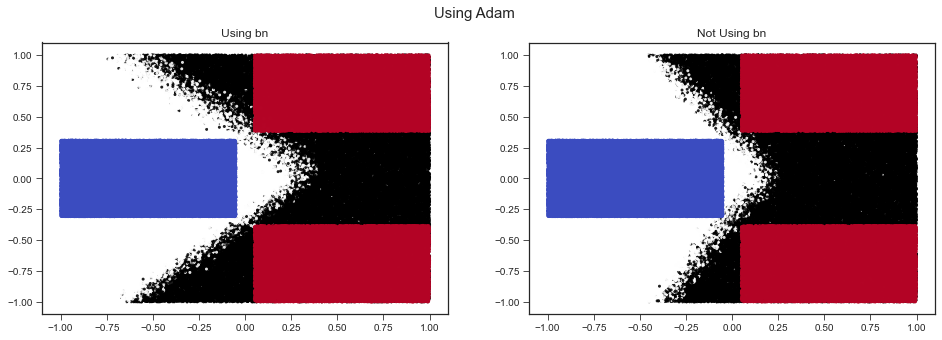

In [ ]:
#Then let's set the optimizer to be Adam
bn_flags = [True, False]

fig, ax = plt.subplots(1,2,figsize=(16, 5))
left_bound = data_config['center'] - data_config['width']
right_bound = data_config['center'] + data_config['width']

for i, flag in enumerate(bn_flags):
    MLP_model_config = {
        'in_dim' : 50,
        'hide_dim' : 100,
        'out_dim' : 2,
        'hidden_layer' : 5,
        'activation' : nn.ReLU,
        'use_activation' : True,
        'use_bn': flag,
        'use_ln': False,
        'dropout' : 0.0
    }
    MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
    lr = 0.01
    opt = optim.Adam(MLP_model.parameters(), lr = lr)
    stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
    final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
    print('Final accuarcy achieved by this model on test set is : {:.3f}'.format(final_acc[0]))

    linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
    simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the linear dim : {:.3f}'.format(simple_randomized_acc[0]))

    slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
    slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the slab3 dim : {:.3f}'.format(slab3_randomized_acc[0]))

    other_randomized_loader = gendata.randomized_loader(data['test_dl'], list(range(2, data_config['dim_num'])))
    other_randomized_acc = synth_models.get_acc(MLP_model, other_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized all the other dims : {:.3f}'.format(other_randomized_acc[0]))

    X_b, Y_b = synth_models.get_boundaries(MLP_model, left_bound, right_bound, 100000, data_config['dim_num'], DEVICE)
    X_b = X_b.cpu()
    Y_b = Y_b.cpu()
    ax[i].scatter(X_b[:,0], X_b[:,1], c=Y_b, cmap='Greys', s=4, alpha=0.8)
    ax[i].scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8)
    if flag:
        ax[i].set_title("Using bn")
    else:
        ax[i].set_title("Not Using bn")
    fig.suptitle('Using Adam', fontsize=15);

training ended after  3043.000 itrs
Final accuarcy achieved by this model on test set is : 1.000
accuarcy after randomized the linear dim : 0.668
accuarcy after randomized the slab3 dim : 0.855
accuarcy after randomized all the other dims : 1.000
training ended after  3201.000 itrs
Final accuarcy achieved by this model on test set is : 0.997
accuarcy after randomized the linear dim : 0.580
accuarcy after randomized the slab3 dim : 0.939
accuarcy after randomized all the other dims : 0.996


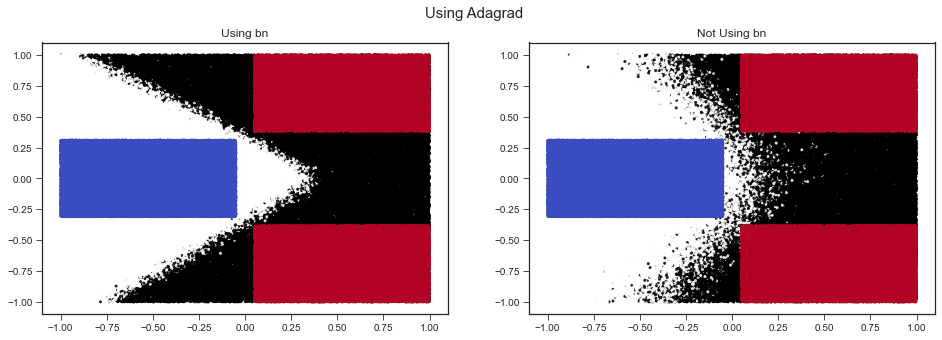

In [ ]:
#Finally let's set the optimizer to be Adagrad
bn_flags = [True, False]

fig, ax = plt.subplots(1,2,figsize=(16, 5))
left_bound = data_config['center'] - data_config['width']
right_bound = data_config['center'] + data_config['width']

for i, flag in enumerate(bn_flags):
    MLP_model_config = {
        'in_dim' : 50,
        'hide_dim' : 100,
        'out_dim' : 2,
        'hidden_layer' : 5,
        'activation' : nn.ReLU,
        'use_activation' : True,
        'use_bn': flag,
        'use_ln': False,
        'dropout' : 0.0
    }
    MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
    lr = 0.2
    opt = optim.Adagrad(MLP_model.parameters(), lr = lr)
    stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
    final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
    print('Final accuarcy achieved by this model on test set is : {:.3f}'.format(final_acc[0]))

    linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
    simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the linear dim : {:.3f}'.format(simple_randomized_acc[0]))

    slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
    slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized the slab3 dim : {:.3f}'.format(slab3_randomized_acc[0]))

    other_randomized_loader = gendata.randomized_loader(data['test_dl'], list(range(2, data_config['dim_num'])))
    other_randomized_acc = synth_models.get_acc(MLP_model, other_randomized_loader, F.cross_entropy, DEVICE)
    print('accuarcy after randomized all the other dims : {:.3f}'.format(other_randomized_acc[0]))

    X_b, Y_b = synth_models.get_boundaries(MLP_model, left_bound, right_bound, 100000, data_config['dim_num'], DEVICE)
    X_b = X_b.cpu()
    Y_b = Y_b.cpu()
    ax[i].scatter(X_b[:,0], X_b[:,1], c=Y_b, cmap='Greys', s=4, alpha=0.8)
    ax[i].scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8)
    if flag:
        ax[i].set_title("Using bn")
    else:
        ax[i].set_title("Not Using bn")
    fig.suptitle('Using Adagrad', fontsize=15);

It's very clear for all of these three optimizers, using batch normalization can decrease the simplicity bias of the trained model greatly. Besides, we find that different optimizaers can effect simplicity bias too. We will now control other setting and change only the optimizer to see its effect

### Try out different optimizer

In [ ]:

stat_dict_optimizer = {}
model_optimizer = {}
repeat_num = 10
for optimizer in [optim.Adam, optim.Adagrad, optim.SGD]:
    stat_dict_optimizer[optimizer] = {}
    stat_dict_optimizer[optimizer]['final_acc'] = []
    stat_dict_optimizer[optimizer]['r1_acc'] = []
    stat_dict_optimizer[optimizer]['r2_acc'] = []
    model_optimizer[optimizer] = []
for optimizer in [optim.Adam, optim.Adagrad, optim.SGD]:
    for i in range(repeat_num):
        MLP_model_config = {
            'in_dim' : 50,
            'hide_dim' : 100,
            'out_dim' : 2,
            'hidden_layer' : 5,
            'activation' : nn.ReLU,
            'use_activation' : True,
            'use_bn': True,
            'use_ln': False,
            'dropout' : 0.0
        }
        MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
        lr = 0.01
        opt = optimizer(MLP_model.parameters(), lr = lr)
        stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
        model_optimizer[optimizer].append(MLP_model)
        final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
        stat_dict_optimizer[optimizer]['final_acc'].append(final_acc[0])

        linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
        simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_optimizer[optimizer]['r1_acc'].append(simple_randomized_acc[0])

        slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
        slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_optimizer[optimizer]['r2_acc'].append(slab3_randomized_acc[0])

training ended after  3155.000 itrs
training ended after  2043.000 itrs
training ended after  2622.000 itrs
training ended after  1275.000 itrs
training ended after  2039.000 itrs
training ended after  3061.000 itrs
training ended after  2796.000 itrs
training ended after  2206.000 itrs
training ended after  3657.000 itrs
training ended after  2493.000 itrs
training ended after  5210.000 itrs
training ended after  6275.000 itrs
training ended after  5537.000 itrs
training ended after  4736.000 itrs
training ended after  4990.000 itrs
training ended after  4808.000 itrs
training ended after  5729.000 itrs
training ended after  4959.000 itrs
training ended after  5706.000 itrs
training ended after  4754.000 itrs
training ended after  23613.000 itrs
training ended after  24357.000 itrs
training ended after  22739.000 itrs
training ended after  24934.000 itrs
training ended after  17736.000 itrs
training ended after  25319.000 itrs
training ended after  21353.000 itrs
training ended after 

In [ ]:
for key, value in stat_dict_optimizer.items():
    print("for optimizer: ", key)
    final_acc = np.mean(value['final_acc'])
    r1_acc = np.mean(value['r1_acc'])
    r2_acc = np.mean(value['r2_acc'])
    print('average final accuarcy : {:.3f}'.format(final_acc))
    print('average accuarcy after randomized the linear dim : {:.3f}'.format(r1_acc))
    print('average accuarcy after randomized the slab3 dim : {:.3f}'.format(r2_acc))

for optimizer:  <class 'torch.optim.adam.Adam'>
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.635
average accuarcy after randomized the slab3 dim : 0.884
for optimizer:  <class 'torch.optim.adagrad.Adagrad'>
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.617
average accuarcy after randomized the slab3 dim : 0.907
for optimizer:  <class 'torch.optim.sgd.SGD'>
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.562
average accuarcy after randomized the slab3 dim : 0.957


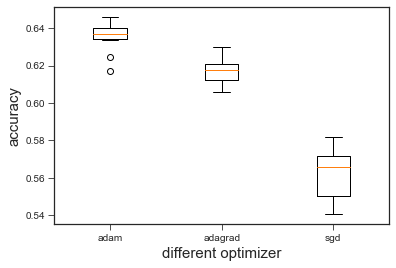

In [ ]:
fig, ax = plt.subplots()
data_plot = []
optimizer = []
for key, value in stat_dict_optimizer.items():
    optimizer.append(str(key).split('.')[-2])
    data_plot.append(value['r1_acc'])
ax.boxplot(data_plot) 
ax.set_xticklabels(optimizer) # 设置x轴刻度标签 
ax.set_xlabel('different optimizer', fontsize=15)
ax.set_ylabel('accuracy', fontsize=15) 
plt.show() 
    

<class 'torch.optim.adam.Adam'>
<class 'torch.optim.adagrad.Adagrad'>
<class 'torch.optim.sgd.SGD'>


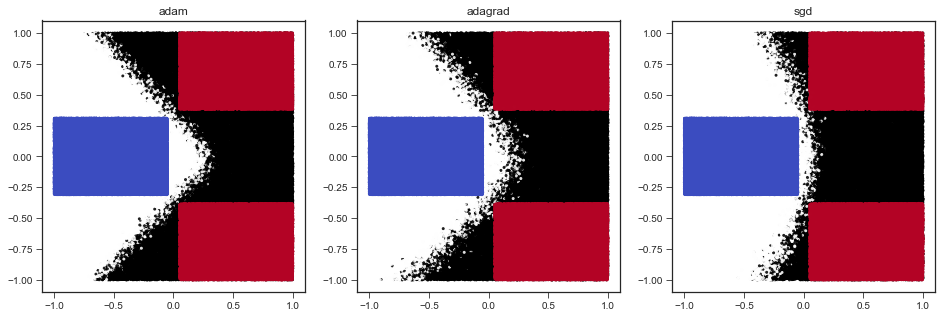

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(16, 5))
left_bound = data_config['center'] - data_config['width']
right_bound = data_config['center'] + data_config['width']

for i, key in enumerate(stat_dict_optimizer):
    X_b, Y_b = synth_models.get_boundaries(model_optimizer[key][2], left_bound, right_bound, 100000, data_config['dim_num'], DEVICE)
    X_b = X_b.cpu()
    Y_b = Y_b.cpu()
    print(key)
    ax[i].scatter(X_b[:,0], X_b[:,1], c=Y_b, cmap='Greys', s=4, alpha=0.8)
    ax[i].scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8)
    ax[i].set_title(str(key).split('.')[-2])

We can see that now with batch normalization, simplicity bias is no longer extreme. The ranking of the effect of these three optimizers on simplicity bias reduction is Adam > Adagrad > SGD

### Try different learning rates on adam

In [ ]:
lr_list = [0.01, 0.0075, 0.005, 0.0025, 0.001]
stat_dict_lr = {}
model_lr = {}
repeat_num = 10
for lr in lr_list:
    stat_dict_lr[lr] = {}
    stat_dict_lr[lr]['final_acc'] = []
    stat_dict_lr[lr]['r1_acc'] = []
    stat_dict_lr[lr]['r2_acc'] = []
    model_lr[lr] = []

for this_lr in lr_list:
    for i in range(repeat_num):
        MLP_model_config = {
            'in_dim' : 50,
            'hide_dim' : 100,
            'out_dim' : 2,
            'hidden_layer' : 5,
            'activation' : nn.ReLU,
            'use_activation' : True,
            'use_bn': True,
            'use_ln': False,
            'dropout' : 0.0
        }
        MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
        lr = this_lr
        opt = optim.Adam(MLP_model.parameters(), lr = lr)
        stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
        model_lr[lr].append(MLP_model)
        final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['final_acc'].append(final_acc[0])

        linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
        simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['r1_acc'].append(simple_randomized_acc[0])

        slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
        slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['r2_acc'].append(slab3_randomized_acc[0])



training ended after  3933.000 itrs
training ended after  2988.000 itrs
training ended after  2845.000 itrs
training ended after  1846.000 itrs
training ended after  3654.000 itrs
training ended after  3418.000 itrs
training ended after  2349.000 itrs
training ended after  2236.000 itrs
training ended after  2385.000 itrs
training ended after  2634.000 itrs
training ended after  2592.000 itrs
training ended after  1741.000 itrs
training ended after  3346.000 itrs
training ended after  2284.000 itrs
training ended after  3313.000 itrs
training ended after  2335.000 itrs
training ended after  2874.000 itrs
training ended after  3166.000 itrs
training ended after  2830.000 itrs
training ended after  2792.000 itrs
training ended after  2758.000 itrs
training ended after  3747.000 itrs
training ended after  2006.000 itrs
training ended after  3617.000 itrs
training ended after  2386.000 itrs
training ended after  2220.000 itrs
training ended after  1850.000 itrs
training ended after  2579.0

In [ ]:
for key, value in stat_dict_lr.items():
    print("for learning rate: ", key)
    final_acc = np.mean(value['final_acc'])
    r1_acc = np.mean(value['r1_acc'])
    r2_acc = np.mean(value['r2_acc'])
    print('average final accuarcy : {:.3f}'.format(final_acc))
    print('average accuarcy after randomized the linear dim : {:.3f}'.format(r1_acc))
    print('average accuarcy after randomized the slab3 dim : {:.3f}'.format(r2_acc))

for learning rate:  0.01
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.629
average accuarcy after randomized the slab3 dim : 0.890
for learning rate:  0.0075
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.629
average accuarcy after randomized the slab3 dim : 0.888
for learning rate:  0.005
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.626
average accuarcy after randomized the slab3 dim : 0.898
for learning rate:  0.0025
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.621
average accuarcy after randomized the slab3 dim : 0.901
for learning rate:  0.001
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.619
average accuarcy after randomized the slab3 dim : 0.907


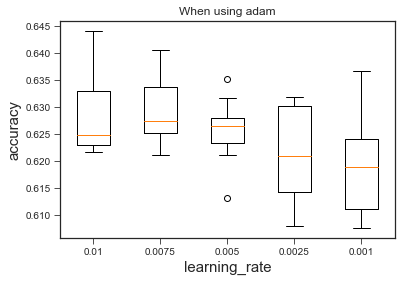

In [ ]:
fig, ax = plt.subplots()
data_plot = []
learning_rate = []
for key, value in stat_dict_lr.items():
    learning_rate.append(str(key))
    data_plot.append(value['r1_acc'])
ax.boxplot(data_plot) 
ax.set_xticklabels(learning_rate) 
ax.set_xlabel('learning_rate', fontsize=15)
ax.set_ylabel('accuracy', fontsize=15) 
ax.set_title("When using adam")
plt.show() 

### Try different learning rates on SGD

In [ ]:
lr_list = [0.8, 0.5, 0.2, 0.1]
stat_dict_lr = {}
model_lr = {}
repeat_num = 10
for lr in lr_list:
    stat_dict_lr[lr] = {}
    stat_dict_lr[lr]['final_acc'] = []
    stat_dict_lr[lr]['r1_acc'] = []
    stat_dict_lr[lr]['r2_acc'] = []
    model_lr[lr] = []

for this_lr in lr_list:
    for i in range(repeat_num):
        MLP_model_config = {
            'in_dim' : 50,
            'hide_dim' : 100,
            'out_dim' : 2,
            'hidden_layer' : 5,
            'activation' : nn.ReLU,
            'use_activation' : True,
            'use_bn': True,
            'use_ln': False,
            'dropout' : 0.0
        }
        MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
        lr = this_lr
        opt = optim.SGD(MLP_model.parameters(), lr = lr)
        stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
        model_lr[lr].append(MLP_model)
        final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['final_acc'].append(final_acc[0])

        linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
        simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['r1_acc'].append(simple_randomized_acc[0])

        slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
        slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_lr[lr]['r2_acc'].append(slab3_randomized_acc[0])

training ended after  3582.000 itrs
training ended after  1809.000 itrs
training ended after  2754.000 itrs
training ended after  3232.000 itrs
training ended after  2863.000 itrs
training ended after  2834.000 itrs
training ended after  3108.000 itrs
training ended after  2446.000 itrs
training ended after  3556.000 itrs
training ended after  2997.000 itrs
training ended after  3204.000 itrs
training ended after  5022.000 itrs
training ended after  3848.000 itrs
training ended after  3187.000 itrs
training ended after  3681.000 itrs
training ended after  2498.000 itrs
training ended after  2436.000 itrs
training ended after  3237.000 itrs
training ended after  2991.000 itrs
training ended after  2149.000 itrs
training ended after  3962.000 itrs
training ended after  4031.000 itrs
training ended after  4398.000 itrs
training ended after  3919.000 itrs
training ended after  3515.000 itrs
training ended after  4072.000 itrs
training ended after  4925.000 itrs
training ended after  3432.0

In [ ]:
for key, value in stat_dict_lr.items():
    print("for learning rate: ", key)
    final_acc = np.mean(value['final_acc'])
    r1_acc = np.mean(value['r1_acc'])
    r2_acc = np.mean(value['r2_acc'])
    print('average final accuarcy : {:.3f}'.format(final_acc))
    print('average accuarcy after randomized the linear dim : {:.3f}'.format(r1_acc))
    print('average accuarcy after randomized the slab3 dim : {:.3f}'.format(r2_acc))

for learning rate:  0.8
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.595
average accuarcy after randomized the slab3 dim : 0.927
for learning rate:  0.5
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.598
average accuarcy after randomized the slab3 dim : 0.924
for learning rate:  0.2
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.591
average accuarcy after randomized the slab3 dim : 0.930
for learning rate:  0.1
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.588
average accuarcy after randomized the slab3 dim : 0.933


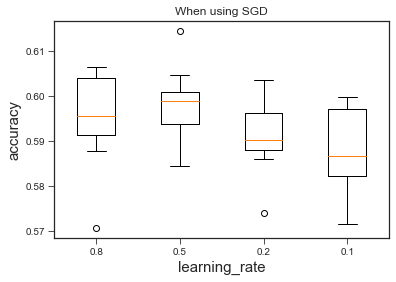

In [ ]:
fig, ax = plt.subplots()
data_plot = []
learning_rate = []
for key, value in stat_dict_lr.items():
    learning_rate.append(str(key))
    data_plot.append(value['r1_acc'])
ax.boxplot(data_plot) 
ax.set_xticklabels(learning_rate) 
ax.set_xlabel('learning_rate', fontsize=15)
ax.set_ylabel('accuracy', fontsize=15) 
ax.set_title("When using SGD")
plt.show() 

### Try different momentum when using SGD

In [105]:
momentum_list = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
stat_dict_mo = {}
model_mo = {}
repeat_num = 10
for mo in momentum_list:
    stat_dict_mo[mo] = {}
    stat_dict_mo[mo]['final_acc'] = []
    stat_dict_mo[mo]['r1_acc'] = []
    stat_dict_mo[mo]['r2_acc'] = []
    model_mo[mo] = []

for this_momentum in momentum_list:
    for i in range(repeat_num):
        MLP_model_config = {
            'in_dim' : 50,
            'hide_dim' : 100,
            'out_dim' : 2,
            'hidden_layer' : 5,
            'activation' : nn.ReLU,
            'use_activation' : True,
            'use_bn': False,
            'use_ln': False,
            'dropout' : 0.0
        }
        MLP_model = synth_models.get_MLP(**MLP_model_config).to(DEVICE)
        lr = 0.3
        opt = optim.SGD(MLP_model.parameters(), lr = lr, momentum = this_momentum)
        stats = synth_models.fit_model(MLP_model, F.cross_entropy, opt, data['train_dl'], data['test_dl'], DEVICE)
        model_mo[this_momentum].append(MLP_model)
        final_acc = synth_models.get_acc(MLP_model, data['test_dl'], F.cross_entropy, DEVICE)
        stat_dict_mo[this_momentum]['final_acc'].append(final_acc[0])

        linear_randomized_loader = gendata.randomized_loader(data['test_dl'], [0])
        simple_randomized_acc = synth_models.get_acc(MLP_model, linear_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_mo[this_momentum]['r1_acc'].append(simple_randomized_acc[0])

        slab3_randomized_loader = gendata.randomized_loader(data['test_dl'], [1])
        slab3_randomized_acc = synth_models.get_acc(MLP_model, slab3_randomized_loader, F.cross_entropy, DEVICE)
        stat_dict_mo[this_momentum]['r2_acc'].append(slab3_randomized_acc[0])

training ended after  1382.000 itrs
training ended after  1169.000 itrs
training ended after  1343.000 itrs
training ended after  1099.000 itrs
training ended after  1238.000 itrs
training ended after  1275.000 itrs
training ended after  1392.000 itrs
training ended after  1133.000 itrs
training ended after  1164.000 itrs
training ended after  1161.000 itrs
training ended after  1098.000 itrs
training ended after  1110.000 itrs
training ended after  921.000 itrs
training ended after  902.000 itrs
training ended after  1096.000 itrs
training ended after  1057.000 itrs
training ended after  1004.000 itrs
training ended after  902.000 itrs
training ended after  987.000 itrs
training ended after  945.000 itrs
training ended after  1280.000 itrs
training ended after  828.000 itrs
training ended after  824.000 itrs
training ended after  841.000 itrs
training ended after  995.000 itrs
training ended after  787.000 itrs
training ended after  1026.000 itrs
training ended after  998.000 itrs
tra

In [106]:
for key, value in stat_dict_mo.items():
    print("for momentum ratio: ", key)
    final_acc = np.mean(value['final_acc'])
    r1_acc = np.mean(value['r1_acc'])
    r2_acc = np.mean(value['r2_acc'])
    print('average final accuarcy : {:.3f}'.format(final_acc))
    print('average accuarcy after randomized the linear dim : {:.3f}'.format(r1_acc))
    print('average accuarcy after randomized the slab3 dim : {:.3f}'.format(r2_acc))

for momentum ratio:  0.0
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.503
average accuarcy after randomized the slab3 dim : 1.000
for momentum ratio:  0.2
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.508
average accuarcy after randomized the slab3 dim : 1.000
for momentum ratio:  0.4
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.514
average accuarcy after randomized the slab3 dim : 0.998
for momentum ratio:  0.6
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.514
average accuarcy after randomized the slab3 dim : 0.997
for momentum ratio:  0.8
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.512
average accuarcy after randomized the slab3 dim : 0.996
for momentum ratio:  0.9
average final accuarcy : 1.000
average accuarcy after randomized the linear dim : 0.511
average accuarcy after randomized the slab

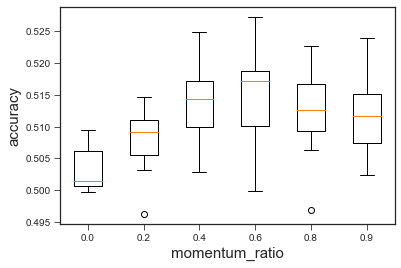

In [107]:
fig, ax = plt.subplots()
data_plot = []
momentum_ratio = []
for key, value in stat_dict_mo.items():
    momentum_ratio.append(str(key))
    data_plot.append(value['r1_acc'])
ax.boxplot(data_plot) 
ax.set_xticklabels(momentum_ratio) 
ax.set_xlabel('momentum_ratio', fontsize=15)
ax.set_ylabel('accuracy', fontsize=15) 
plt.show() 